# Colorectal Cancer EDA
Notebook author: Shweta Chandole

Date: Jul 03, 2022

<a id='start'></a>
## Project Details

- Create EDA and develop ML classification models to identify the likelihood of a cancer diagnosis for a patient based on the symptoms reported early on in the consultation process. This project makes use of the colorectal cancer dataset described in this article - (https://www.nature.com/articles/6602714).

- This notebook focuses on Exploratory Data Analysis (EDA) of the said colorectal dataset

## Importing Libraries

In [1]:
# import libraries for data manipulation
import numpy as np
import pandas as pd
from numpy import mean, std

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import library for preparing data
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

# import libraries for building classifier models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from statsmodels.graphics.gofplots import ProbPlot

# import libraries for performance metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, balanced_accuracy_score, roc_auc_score 

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [2]:
sns.set_theme(context='notebook', style='darkgrid', palette='dark', font='sans-serif', font_scale=1, color_codes=True, rc=None)

## Data Preparation

### Loading the data

In [14]:
# reading original colrectal dataset
data_crc_orig = pd.read_csv('/content/CRC_original_dataset.csv')

In [15]:
# copy dataset to new variables
df_crc = data_crc_orig.copy()

In [16]:
# check for shape and first few records of dataset
df_crc.shape

(2093, 1259)

### Identifying target variable and classes

In [17]:
print("Case_Control: ")
print(df_crc['Case_Control'].value_counts())
print("\nControl_Case: ") 
print(df_crc['Control_Case'].value_counts())

Case_Control: 
0    1744
1     349
Name: Case_Control, dtype: int64

Control_Case: 
1.0    1744
0.0     349
Name: Control_Case, dtype: int64



|index|count|mean|std|min|25%|50%|75%|max|
|---|---|---|---|---|---|---|---|---|
|Case\_Control|2093\.0|0\.16674629718107978|0\.3728382831911263|0\.0|0\.0|0\.0|0\.0|1\.0|
|Control\_Case|2093\.0|0\.8332537028189202|0\.3728382831911263|0\.0|1\.0|1\.0|1\.0|1\.0|


##### Observations
- Case_Control indicates the binary class distribution in the proportion 1744 Controls studied (class 0) at 83.33% to 349 Cases studied (class 1) at 16.67%
- Class 1 (Cases) is the minoriity class, and also the desired class here since we are looking at early detection
- Column Control_Case shall be dropped due to the redundant nature of this column




## Data pre-processing and feature engineering

### Introducing feature: Status 

- Adding column Status to identify Case (Cases i.e. class 0 Vs. Control (Control i.e. class 1)

In [18]:
df_crc.loc[df_crc.Case_Control == 0, 'STATUS'] = 'Control - No Cancer'
df_crc.loc[df_crc.Case_Control == 1, 'STATUS'] = 'Case - Diagnosed'

### Introducing feature: Gender
- Adding column Gender based on column Sex, as Male for 0 and Female for 1 
- [Reference](https://docs.google.com/spreadsheets/d/14dWHmPsDGC48P8v-8xCYDxRlPmjJNt_e/edit#gid=842469682)

In [19]:
df_crc.loc[df_crc.Sex == 0, 'GENDER'] = 'Male'
df_crc.loc[df_crc.Sex == 1, 'GENDER'] = 'Female'

### Drop redundant columns

In [20]:
# drop column Control_Case from crc data, which is opposite of Case_control and is redundant for our purpose
df_crc.drop(['Control_Case'], axis=1, inplace = True)

In [21]:
# drop primary key column from crc
df_crc.drop(df_crc.columns[[0]], axis = 1, inplace = True)

In [22]:
# drop empty columns from crc, if any
df_crc.dropna(1, 'all')
df_crc.shape

(2093, 1259)

### Rename selected features

In [23]:
df_crc_select = df_crc.copy()
df_crc_select.shape

(2093, 1259)

In [24]:
# renaming select features based on Prof. Hamilton's reference research papers
df_crc_select.rename(columns = {'code_D11_1st' : 'diarrhoea',
'code_D12_1st' : 'constipation',
'code_T03_1st' : 'loss_of_appetite',
'code_T08_1st' : 'weight_loss',
'code_D16_1st' : 'rectal_bleeding',
'code_D01_1st' : 'abdominal_pain_general',
'code_D06_1st' : 'abdominal_pain_localized',
'code_D09_1st' :	'nausea',
'code_D10_1st' :	'vomiting',
'code_D01_frequency' : 'abdo_pain_gen_freq',
'code_D06_frequency' : 'abdo_pain_loc_freq',
'code_D10_frequency' : 'vom_freq',
'code_D11_frequency' : 'dirh_freq',
'code_D16_frequency' : 'RB_freq',
'LOW_score'	:	'loss_of_weight_score'
}, inplace=True)
#print(df_crc_select.columns)

In [25]:
renamed_cols = ['diarrhoea',
'constipation',
'loss_of_appetite',
'weight_loss',
'rectal_bleeding',
'abdominal_pain_general',
'abdominal_pain_localized',
'nausea',
'vomiting',
'abdo_pain_gen_freq',
'abdo_pain_loc_freq',
'vom_freq',
'dirh_freq',
'RB_freq',
'loss_of_weight_score']

### Feature Selection
- Creating lists of features based on the patient characteristics, selected symptoms, corresponding symptom frequencies and symptom scores, and diabetes related features from the dataset
- The features renaming and selection work is documented in this excelsheet - [Feature selection - CRC](https://docs.google.com/spreadsheets/d/1NQFYomL-PzVKh4OGyAqjKGXkQGvK9x4BJMvJs_LCmC0/edit#gid=749913904)

In [26]:
crc_spec_cols = ["Case_Control",
"STATUS",
"GENDER",
"age_at_dendrite_date",
"age_case",
"age_band",
"age_group",
"definite_check_exclude",
"cancer_staging"]

In [27]:
crc_symp_cols = ["Case_Control",
                 "GENDER",
                 "loss_of_appetite",
"weight_loss",
"abdominal_pain",
"abdominal_pain_general",
"abdominal_pain_localized",
"nausea",
"vomiting",
"diarrhoea",
"constipation",
"rectal_bleeding",
"haematochezia",
"inv_FOB_positive"]

In [28]:
crc_symp_freq_cols = ["Case_Control", "STATUS", "GENDER", "abdominal_pain_frequency",
"abdo_pain_gen_freq",
"abdo_pain_loc_freq",
"vom_freq",
"dirh_freq",
"RB_freq"]

In [29]:
crc_symp_score_cols = ["Case_Control", "STATUS", "GENDER", "loss_of_weight_score",
"abdo_pain_score",
"diarrhoea_score",
"constipation_score",
"RB_score",
"FOB_score",
"anaemia_score"]

In [30]:
crc_diab_cols = ["Case_Control", "STATUS", "GENDER", "diabetes_tested",
"labelled_diabetic",
"diabetic_control_poor",
"sugar_score"]

In [31]:
crc_inv_cols = ["Case_Control", "STATUS", "GENDER", "inv_BP_normal_1st",
"inv_BP_raised_1st",
"inv_Ba_enema_Ca_suspected",
"inv_Ba_enema_abnormal",
"inv_CXR_abnormal",
"inv_CXR_normal",
"inv_ECG_normal",
"inv_MSU_RBC_abnormal",
"inv_MSU_RBC_normal",
"inv_MSU_WCC_abnormal",
"inv_MSU_WCC_normal",
"inv_MSU_growth_positive",
"inv_MSU_no_growth",
"inv_PR_Ca_suspected",
"inv_PR_abnormal",
"inv_PR_normal_1st",
"inv_abdo_US_abnormal",
"inv_abdo_US_normal",
"inv_cervical_smear_normal",
"inv_colonoscopy_abnormal",
"inv_colonoscopy_normal",
"inv_other_XR_abnormal",
"inv_other_XR_normal",
"inv_stool_culture_negative",
"inv_FOB_positive",
"inv_urinalysis_normal_1st",
"inv_urinalysis_normal_2nd"]

In [32]:
crc_other_symp_cols = ["Case_Control", "STATUS", "GENDER", "code_D02_1st",
"code_D03_1st",
"code_D07_1st",
"code_D08_1st",
"code_D17_1st",
"code_D18_1st",
"code_D19_1st",
"code_D20_1st",
"code_D21_1st",
"code_D23_1st",
"code_D24_1st",
"code_D25_1st",
"code_D29_1st",
"code_D78_1st",
"code_D92_1st",
"code_D93_1st",
"code_D99_1st"]

## Exploratory Data Analysis

#### Patient Characteristics by Cancer Status


STATUS


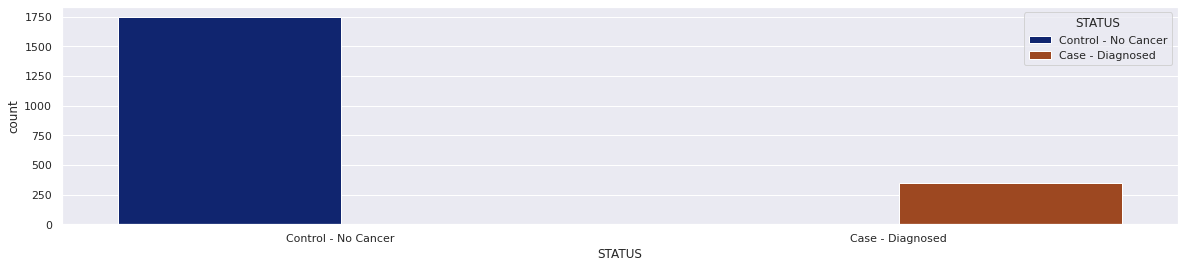

GENDER


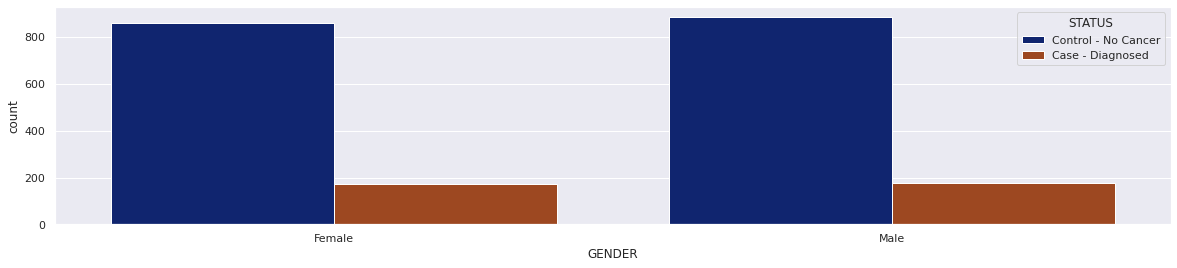

age_band


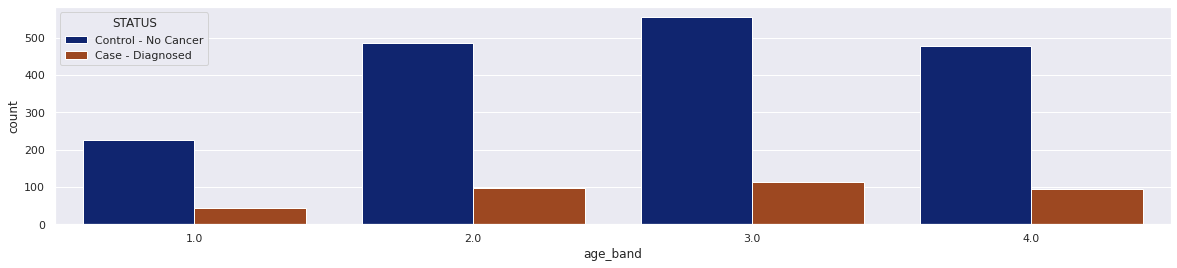

age_group


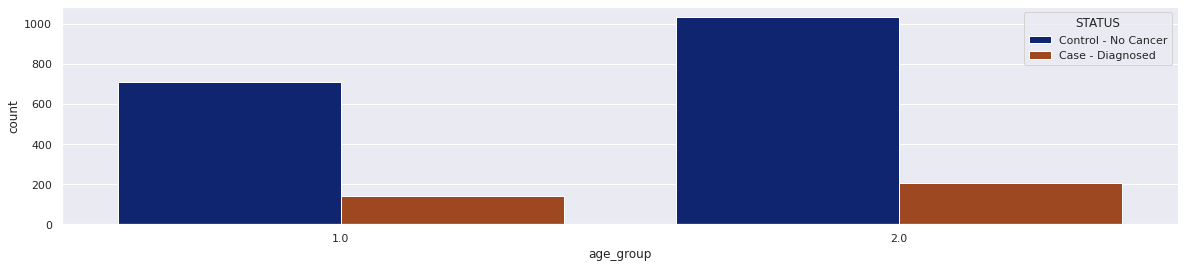

definite_check_exclude


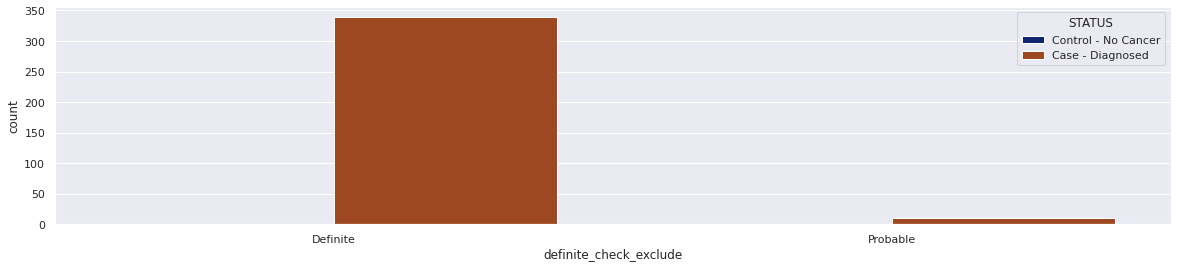

cancer_staging


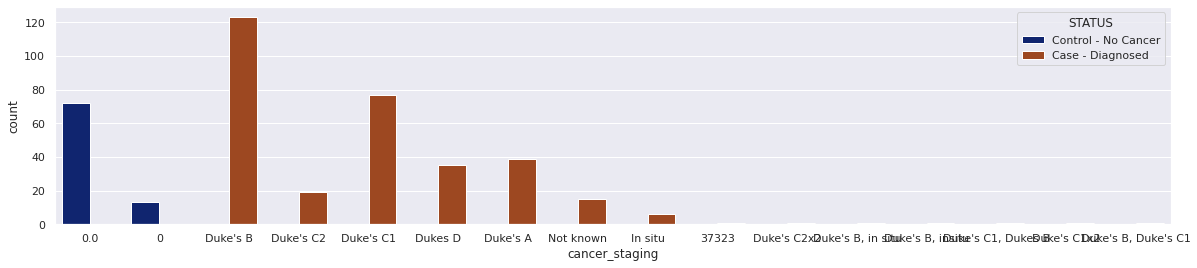

In [35]:
# patient characteristics by cancer status
for i in crc_spec_cols[1:3]+crc_spec_cols[5:]:
    print(i)
    plt.figure(figsize=(20, 4))
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.show()

#### Patient Characteristics by Gender

STATUS


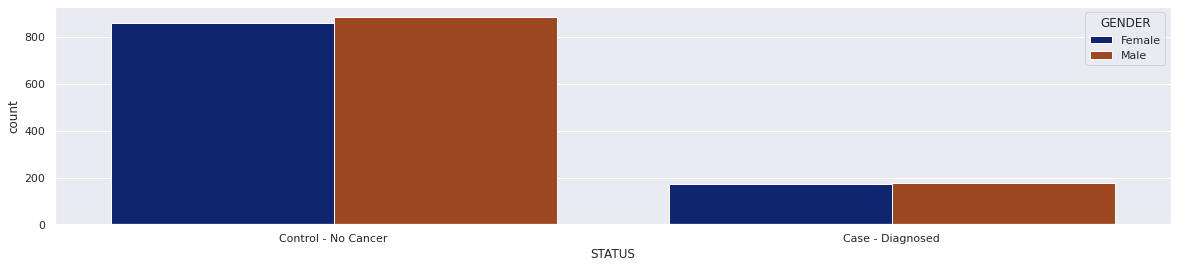

age_band


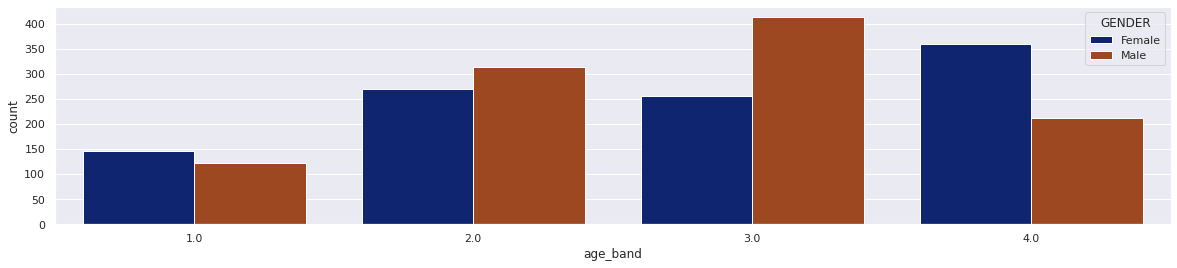

age_group


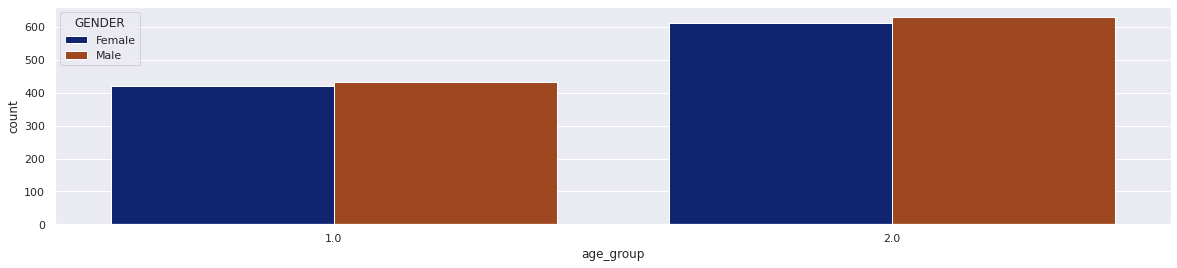

definite_check_exclude


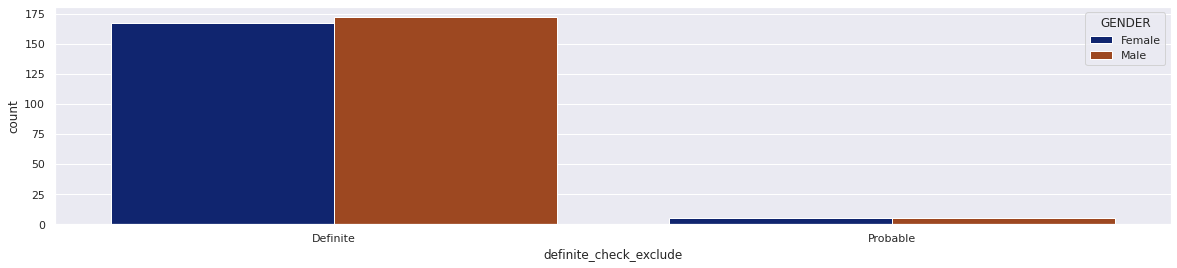

cancer_staging


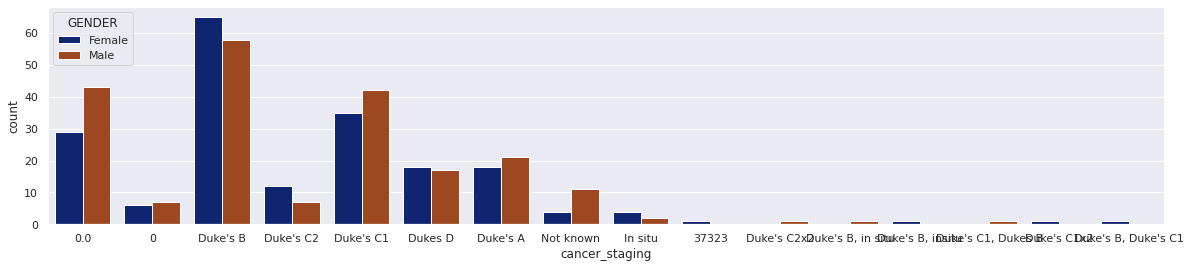

In [36]:
# patient characteristics by gender
for i in crc_spec_cols[1:2]+crc_spec_cols[5:]:
    print(i)
    plt.figure(figsize=(20, 4))
    sns.countplot(x = df_crc_select[i], hue='GENDER', data=df_crc_select)
    plt.show()

##### Observations
- More Female patients than Male patients are observed to be in the stages - Duke's B, Duke's D, In situ as compared to rest of the stages

#### Selected Symptoms by Cancer status and Gender

weight_loss


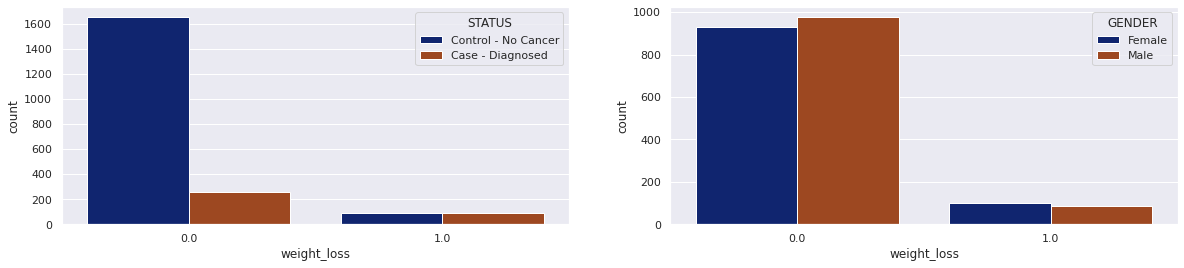



abdominal_pain


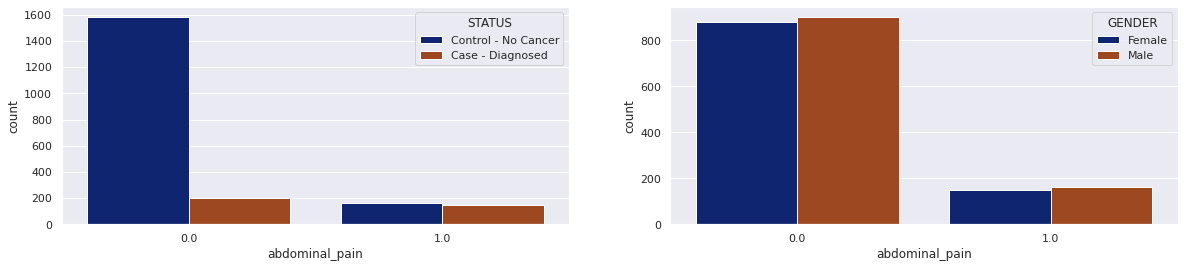



abdominal_pain_general


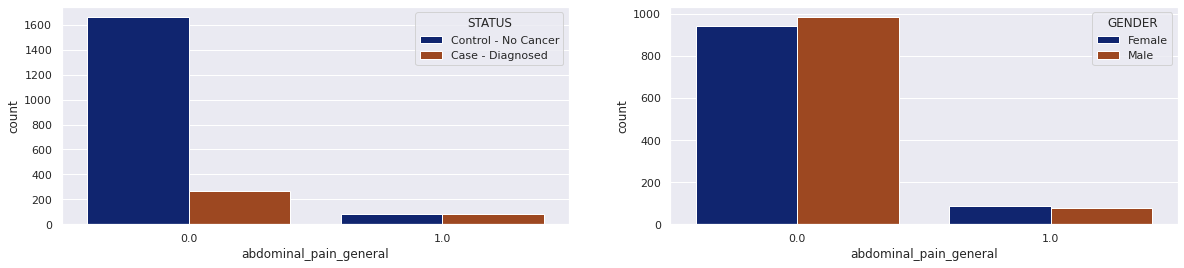



abdominal_pain_localized


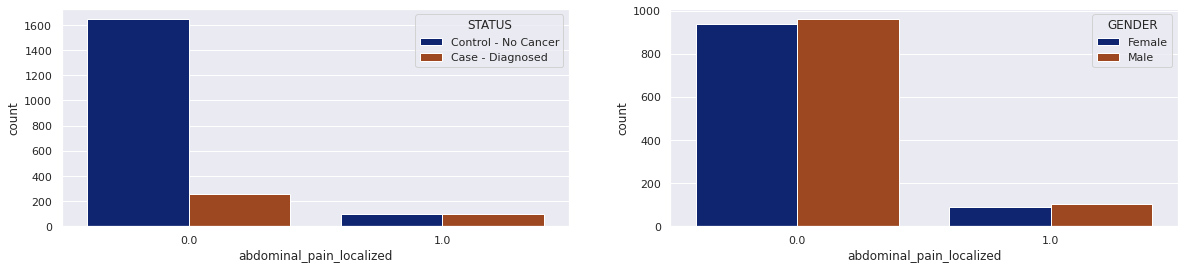



nausea


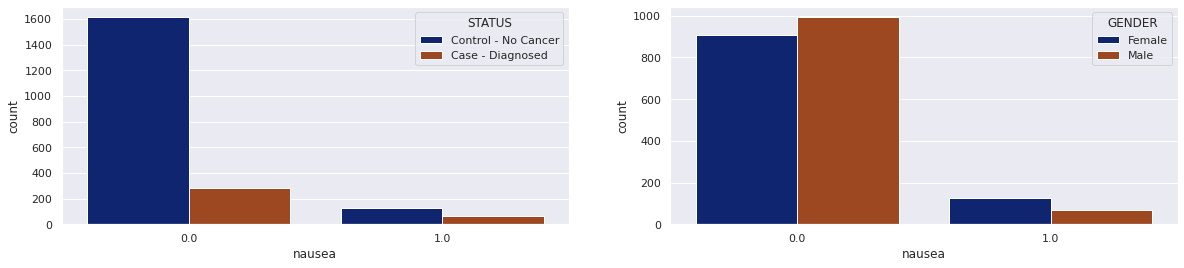



vomiting


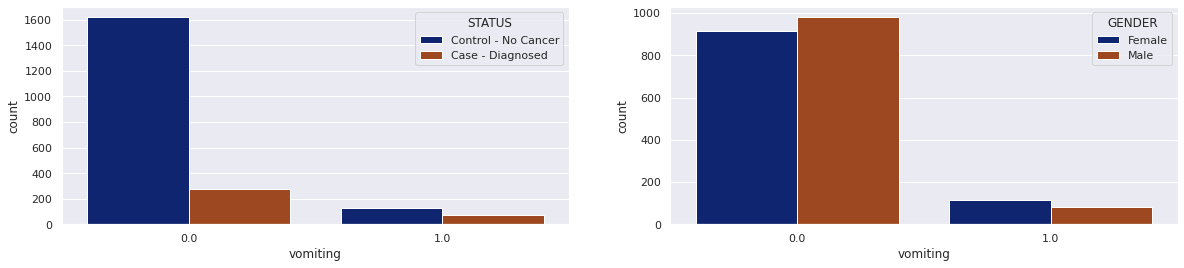



diarrhoea


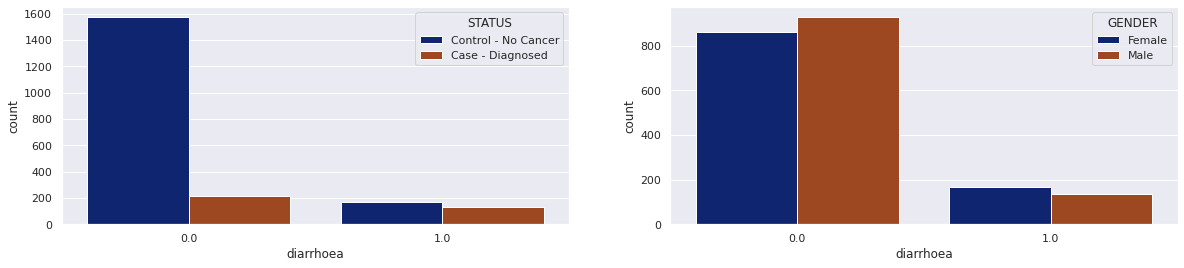



constipation


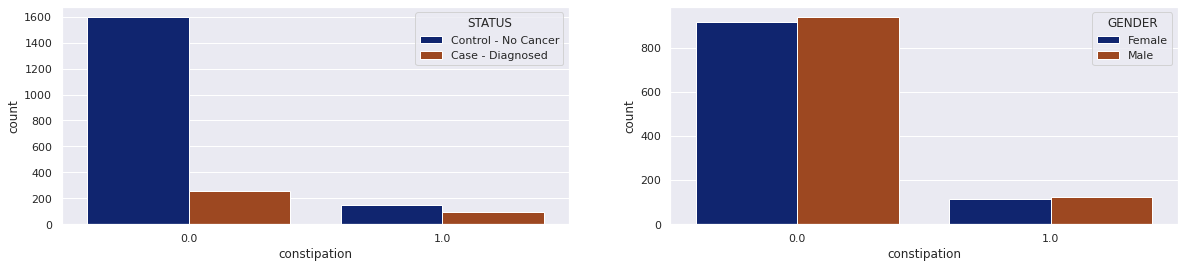



rectal_bleeding


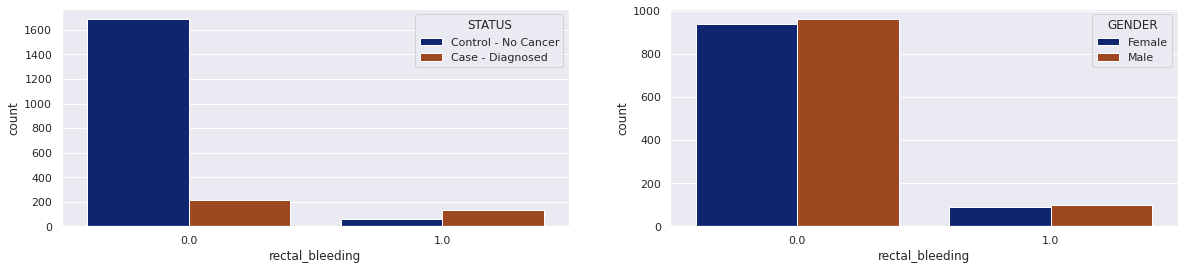



haematochezia


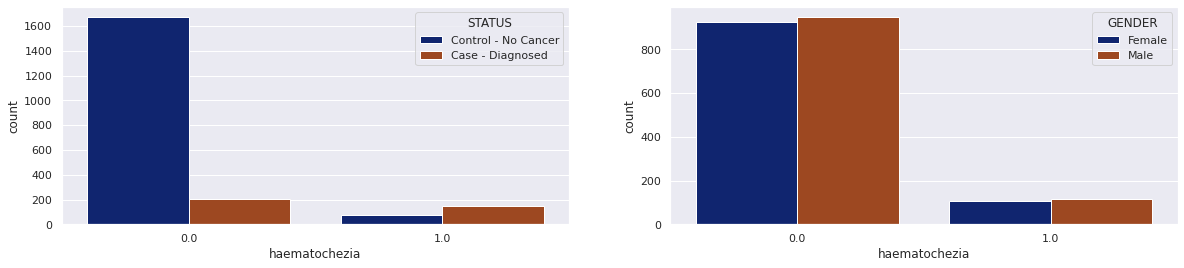



inv_FOB_positive


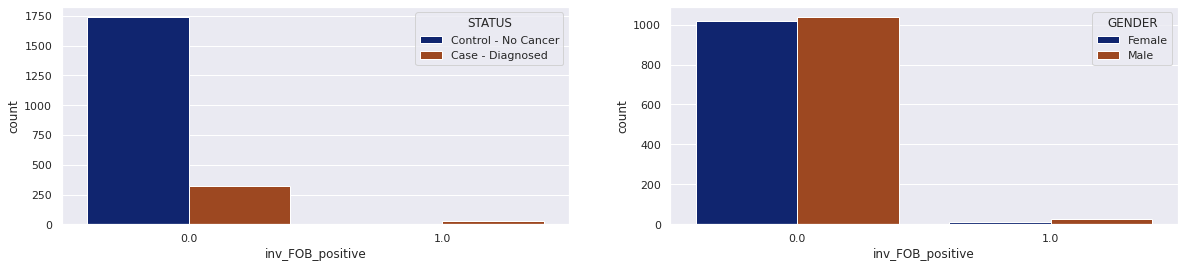

In [38]:
# Selected symptoms by cancer status and gender
for i in crc_symp_cols[3:]:
    print(i)
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.subplot(1,2,2)
    sns.countplot(x = df_crc_select[i], hue='GENDER', data=df_crc_select)
    plt.show()
    print('\n')

    

##### Observations
- Higher count of Female patients observed for the symptoms weight loss, abdominal pain- general, nausea, vomiting, diarrhoea
- Higher count of Male patients observed for symptoms other than listed above

#### Symptoms Frequency vs. cancer case status

abdominal_pain_frequency


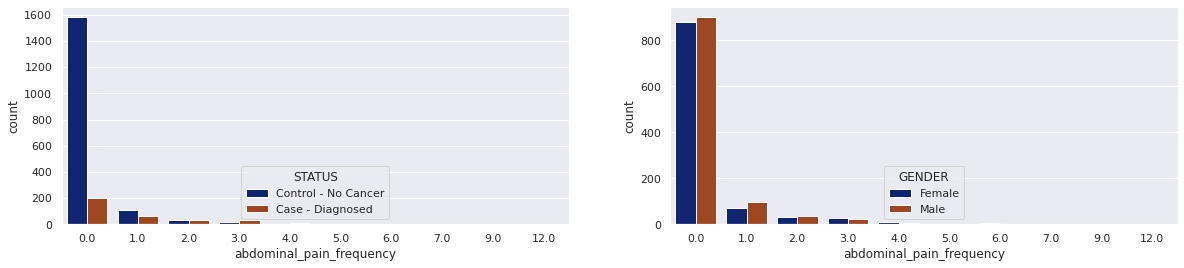



abdo_pain_gen_freq


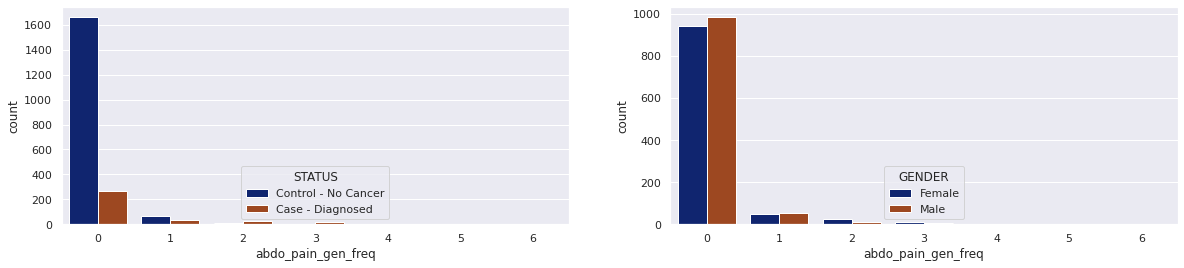



abdo_pain_loc_freq


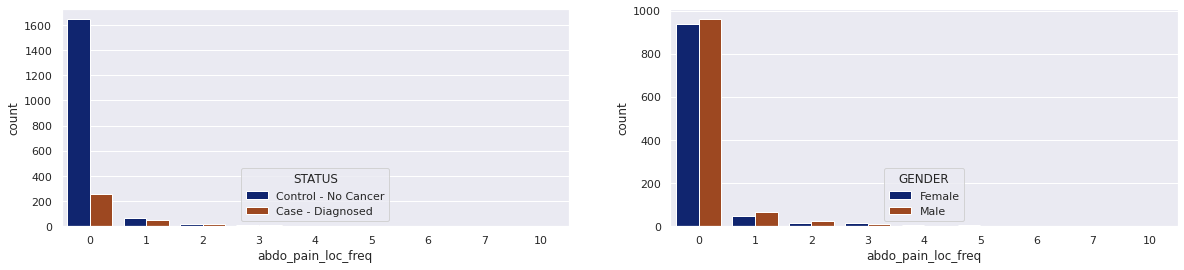



vom_freq


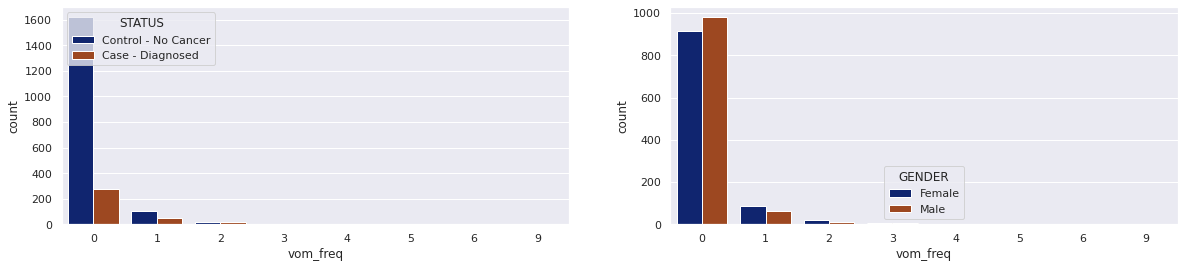



dirh_freq


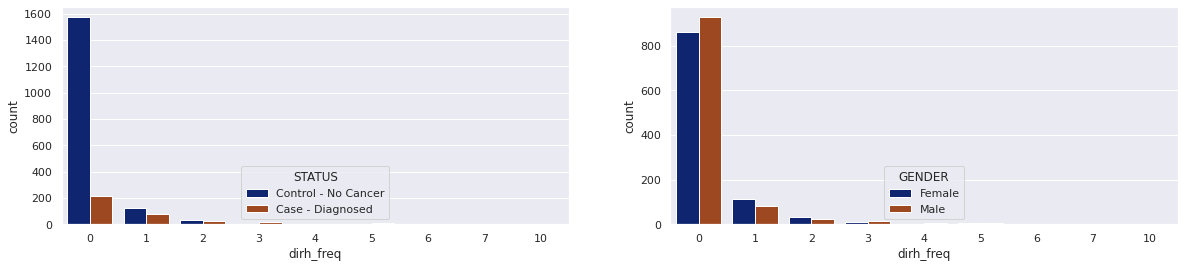



RB_freq


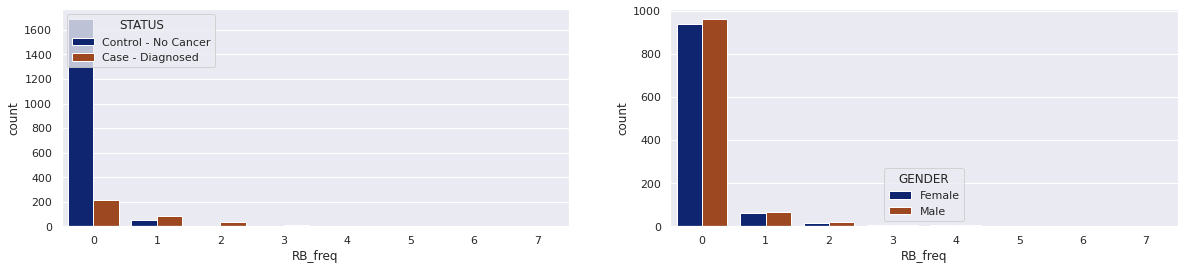

In [39]:
# Symptoms frequency by cancer status and gender
for i in crc_symp_freq_cols[3:]:
    print(i)
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.subplot(1,2,2)
    sns.countplot(x = df_crc_select[i], hue='GENDER', data=df_crc_select)
    plt.show()
    print('\n')

#### Symptom Scores vs. cancer case status

loss_of_weight_score


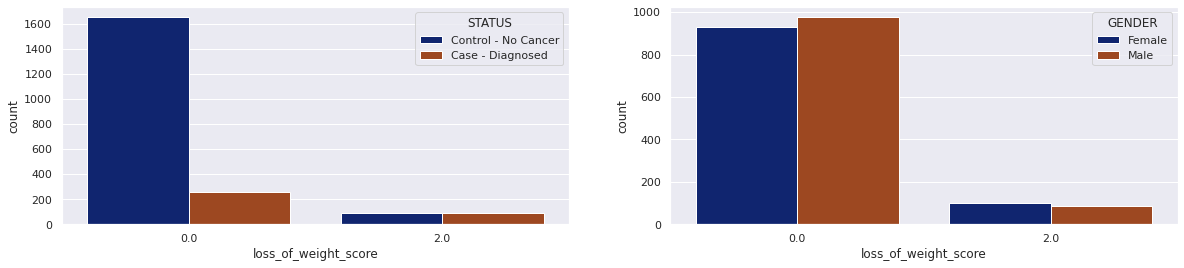



abdo_pain_score


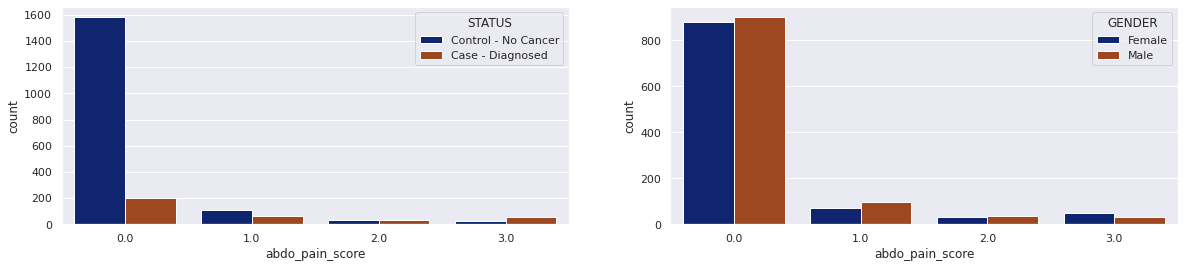



diarrhoea_score


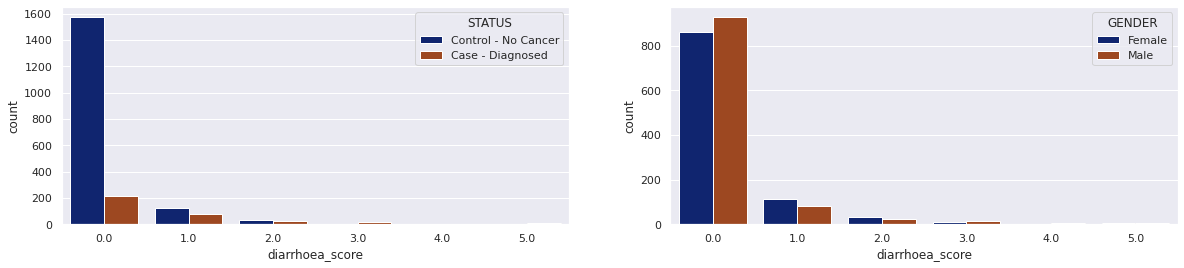



constipation_score


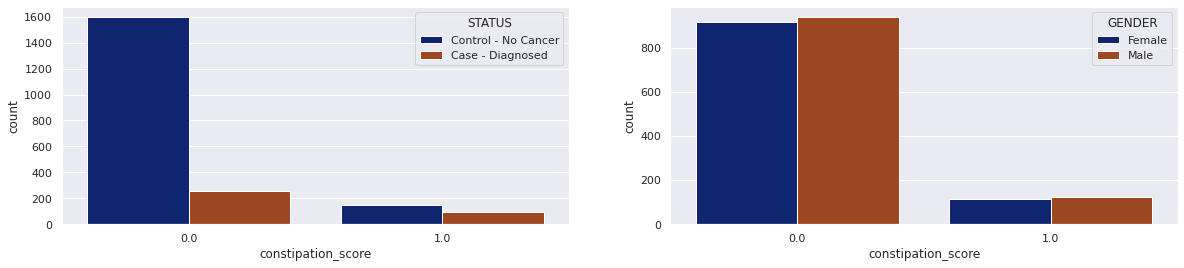



RB_score


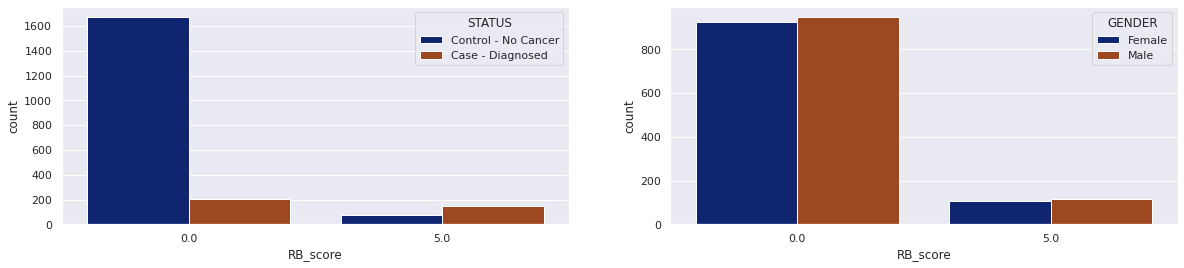



FOB_score


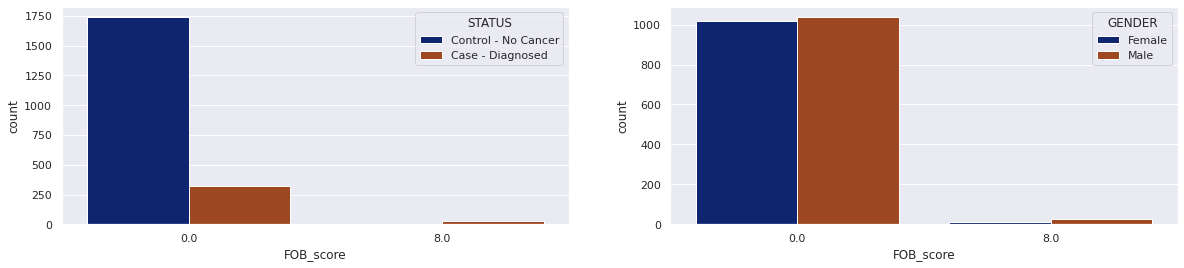



anaemia_score


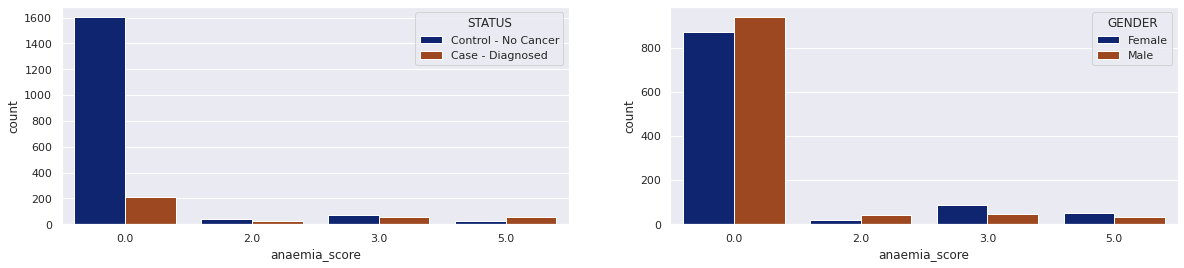

In [40]:
# Symptom scores by cancer status and gender
for i in crc_symp_score_cols[3:]:
    print(i)
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.subplot(1,2,2)
    sns.countplot(x = df_crc_select[i], hue='GENDER', data=df_crc_select)
    plt.show()
    print('\n')

#### Diabetes specs by Cancer Status and Gender 

diabetes_tested


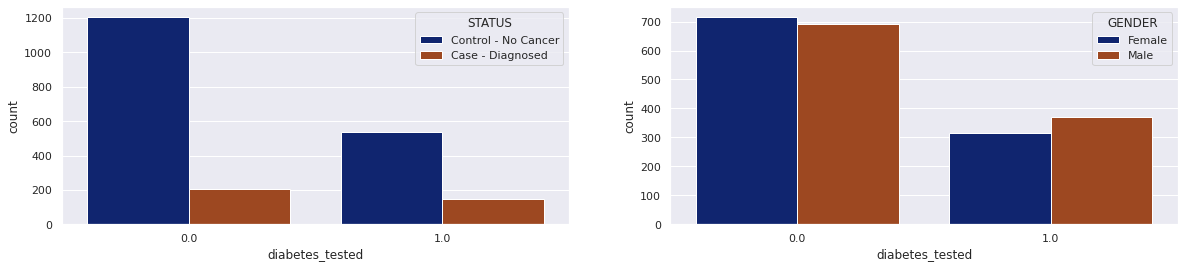



labelled_diabetic


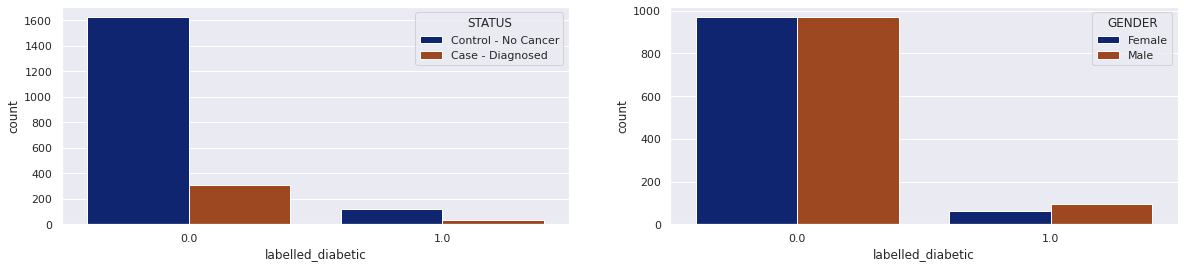



diabetic_control_poor


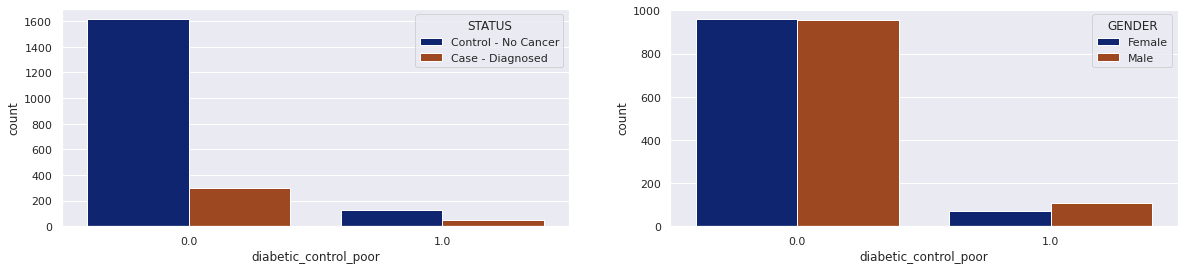



sugar_score


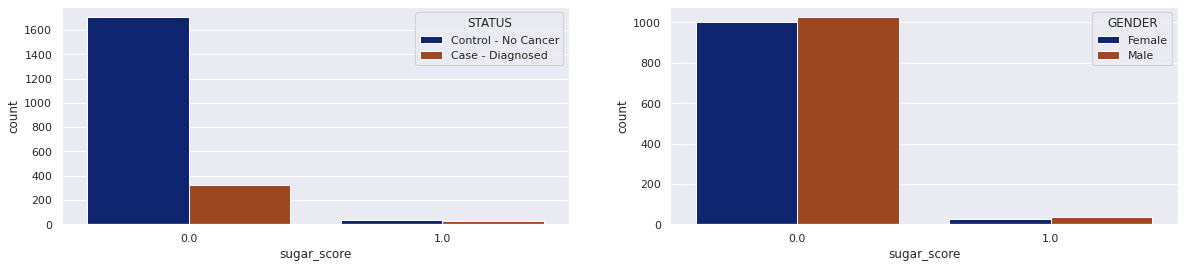

In [41]:
# Diabetes specs by cancer status and gender
for i in crc_diab_cols[3:]:
    print(i)
    plt.figure(figsize=(20, 4))
    plt.subplot(1,2,1)
    sns.countplot(x = df_crc_select[i], hue='STATUS', data=df_crc_select)
    plt.subplot(1,2,2)
    sns.countplot(x = df_crc_select[i], hue='GENDER', data=df_crc_select)
    plt.show()
    print('\n')

#### Selected Symptoms correlation clustermap

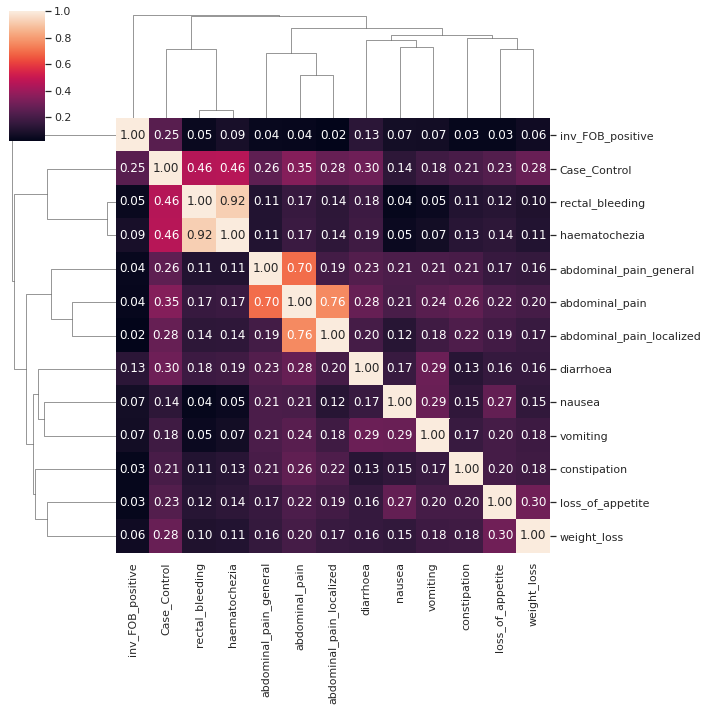

In [ ]:
sns.clustermap(df_crc_select[crc_symp_cols].corr(method='kendall').abs(),annot=True, fmt = ".2f")

#### Symptom frequencies correlation clustermap

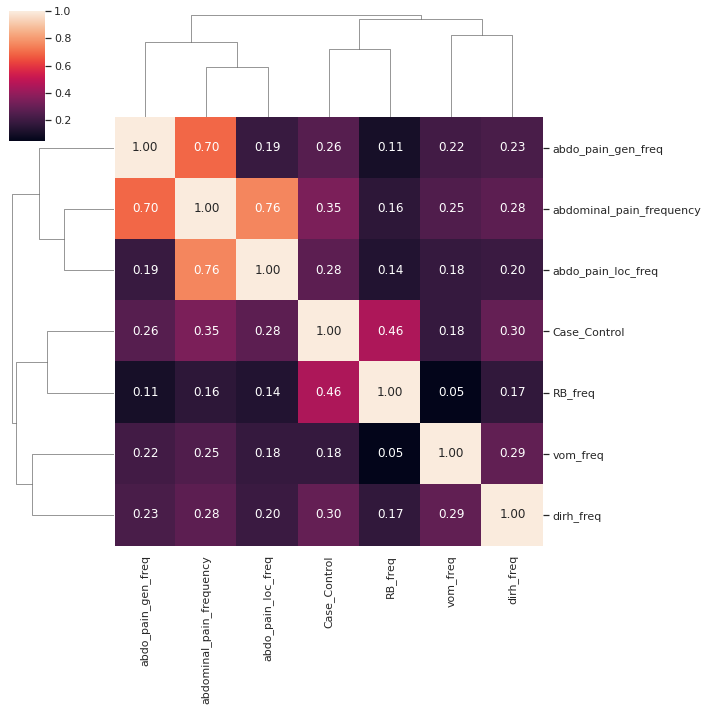

In [ ]:
sns.clustermap(df_crc_select[crc_symp_freq_cols].corr(method='kendall').abs(),annot=True, fmt = ".2f")

#### Symptoms scores correlation clustermap

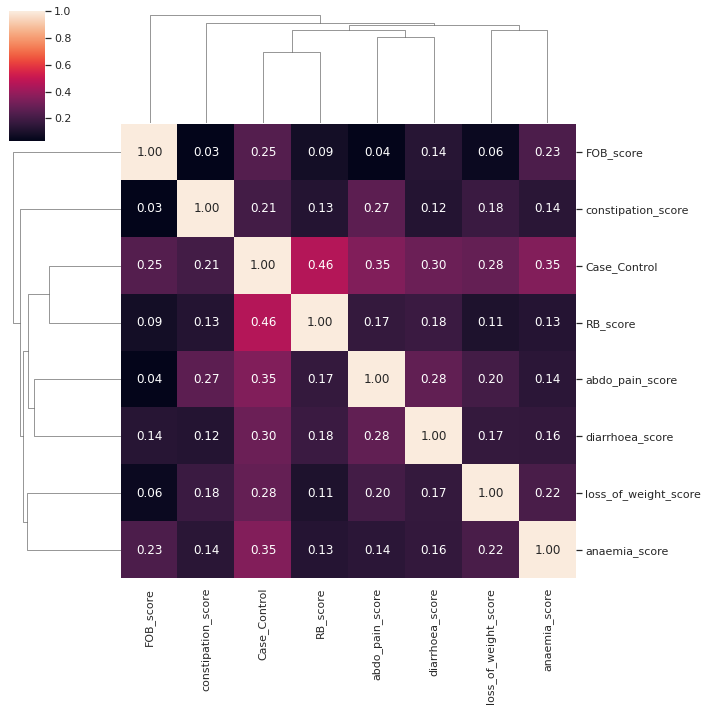

In [ ]:
sns.clustermap(df_crc_select[crc_symp_score_cols].corr(method='kendall').abs(),annot=True, fmt = ".2f")